In [ ]:
from __future__ import annotations

import os

import matplotlib.pyplot as plt
import numpy as np

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats("png")

from data import mat_utils
from data.dataset import Dataset1, Dataset4

In [2]:
!ls ~/data/BCI

1_EEG_LRhandMI  4_EEG_6StatesMI


## Dataset 1: Left/Right Hand MI
Includes 52 subjects (38 validated subjects with discriminative features), results of physiological and psychological questionnares, EMG Datasets, location of 3D EEG electrodes, and EEGs for non-task related states.

### DS1 File Contents

In [3]:
DATASET1_PATH = os.path.expanduser('~/data/BCI/1_EEG_LRhandMI')
print(DATASET1_PATH)
print(os.listdir(DATASET1_PATH)[:5])

/Users/anna/data/BCI/1_EEG_LRhandMI
['trial_sequence', 'paper.pdf', '.DS_Store', 's38.mat', 's39.mat']


In [4]:
subject1_path = os.path.join(DATASET1_PATH, 's38.mat')
mat_utils.print_top_level_keys(subject1_path)

['eeg']


In [5]:
mat_utils.print_key_info(subject1_path, 'eeg')

`eeg` keys: ['noise', 'rest', 'srate', 'movement_left', 'movement_right', 'movement_event', 'n_movement_trials', 'imagery_left', 'imagery_right', 'n_imagery_trials', 'frame', 'imagery_event', 'comment', 'subject', 'bad_trial_indices', 'psenloc', 'senloc']
noise                ndarray         shape=(5,) dtype=object
rest                 ndarray         shape=(68, 34048) dtype=float32
srate                int             value=512
movement_left        ndarray         shape=(68, 71680) dtype=float32
movement_right       ndarray         shape=(68, 71680) dtype=float32
movement_event       ndarray         shape=(71680,) dtype=uint8
n_movement_trials    int             value=20
imagery_left         ndarray         shape=(68, 358400) dtype=float32
imagery_right        ndarray         shape=(68, 358400) dtype=float32
n_imagery_trials     int             value=100
frame                ndarray         shape=(2,) dtype=int16
imagery_event        ndarray         shape=(358400,) dtype=uint8
comment

### DS1 Data Examples

In [6]:
ds1 = Dataset1(DATASET1_PATH)
ds1.print_info()

Total subjects: 18
Epoch window: 0.500–2.500 s
Total subject data: 910.00 MB


In [7]:
ds1_subject38 = ds1.get_subject(38)
ds1_subject38.print_info()

Subject ID: 38
sampling_rate: 512, n_trials: 200, n_channels: 64, n_samples: 1024
X: (200, 64, 1024), Y: (200,)


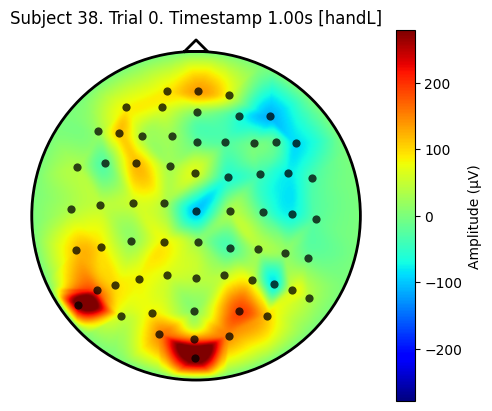

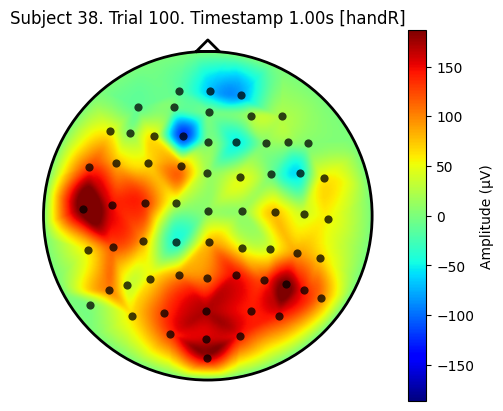

In [8]:
ds1_subject38.plot_head(trial=0, timestamp=1.0, plot_joint=True)

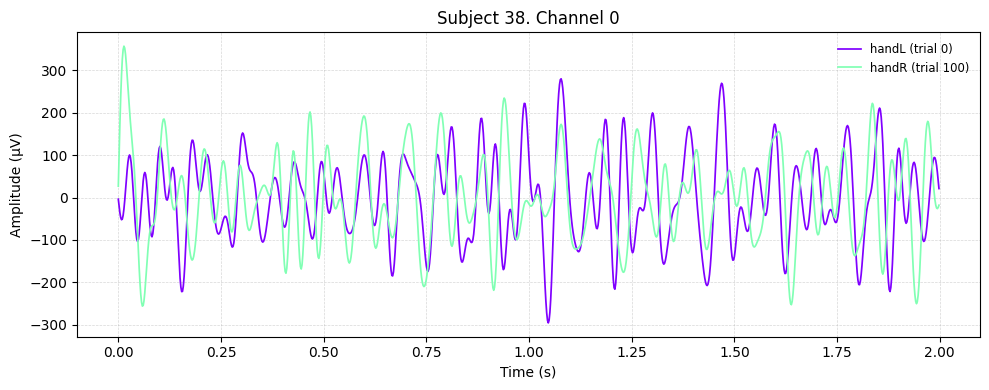

In [9]:
ds1_subject38.plot_channel(trial=0, channel=0)

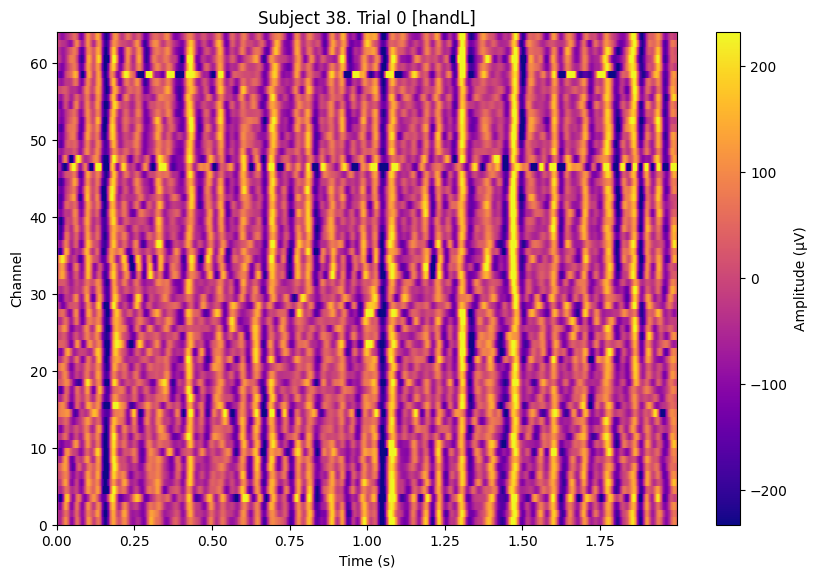

In [10]:
ds1_subject38.plot_trial_heatmap(trial=0)

## Dataset 4: The largest SCP data of Motor-Imagery
The dataset contains 60 hours of EEG BCI recordings across 75 recording sessions of 13 participants, 60,000 mental imageries, and 4 BCI interaction paradigms, with multiple recording sessions and paradigms of the same individuals. BCI interactions involving up to 6 mental imagery states are considered.

### DS4 File Contents

In [3]:
DATASET4_PATH = os.path.expanduser('~/data/BCI/4_EEG_6StatesMI')
print(DATASET4_PATH)
print(os.listdir(DATASET4_PATH)[:5])

/Users/anna/data/BCI/4_EEG_6StatesMI
['paper.pdf', '1Description.txt', 'HaLTSubjectB1602256StLRHandLegTongue.mat', 'HaLTSubjectB1602186StLRHandLegTongue.mat', 'HaLTSubjectA1603086StLRHandLegTongue.mat']


In [4]:
subject4_path = os.path.join(DATASET4_PATH, 'HaLTSubjectB1602186StLRHandLegTongue.mat')
mat_utils.print_top_level_keys(subject4_path)

['o']


In [5]:
mat_utils.print_key_info(subject4_path, 'o')

`o` keys: ['id', 'tag', 'sampFreq', 'nS', 'marker', 'data', 'chnames', 'binsuV']
id                   str             value=201602181925.D091BB44
tag                  str             value=NK-data import (auto)
sampFreq             int             value=200
nS                   int             value=666400
marker               ndarray         shape=(666400,) dtype=uint8
data                 ndarray         shape=(666400, 22) dtype=float64
chnames              ndarray         shape=(22,) dtype=object
binsuV               int             value=1


### DS4 Data Examples

In [6]:
ds4 = Dataset4(DATASET4_PATH)
ds4.print_info()

Total subjects: 5
Epoch window: 0.000–0.850 s
Total subject data: 130.46 MB


In [7]:
print(', '.join(ds4.subject_ids()))

A1602236S, A1603086S, A1603106S, B1602186S, B1602256S


In [8]:
ds4_subject = ds4.get_subject('A1602236S')
ds4_subject.print_info()

Subject ID: A1602236S
sampling_rate: 200, n_trials: 959, n_channels: 21, n_samples: 170
X: (959, 21, 170), Y: (959,)


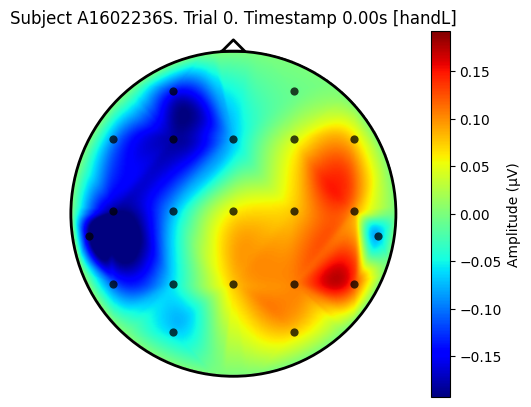

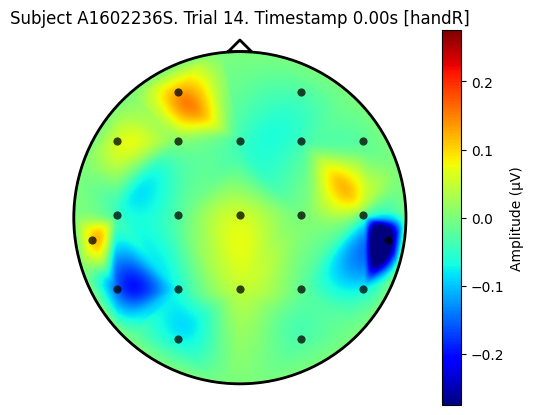

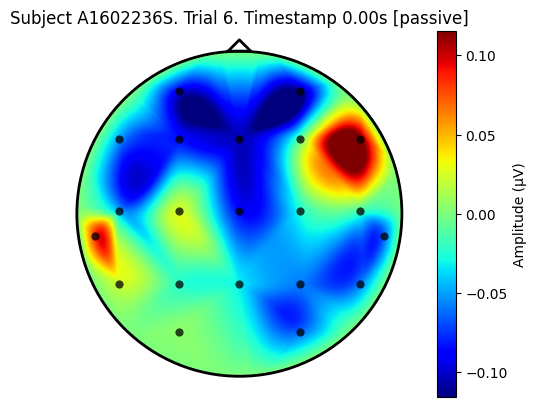

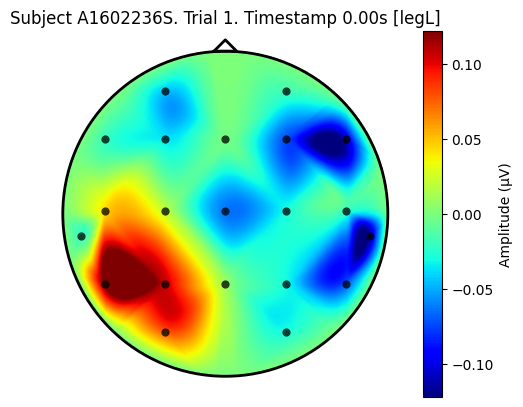

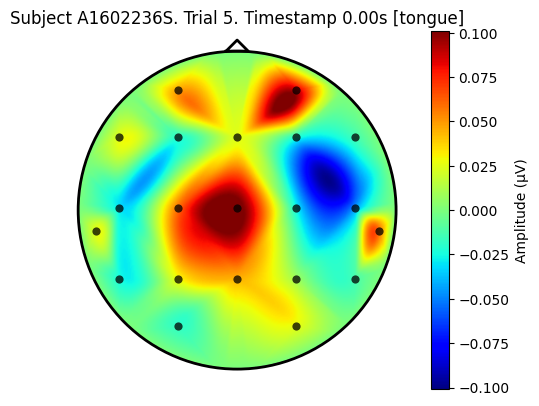

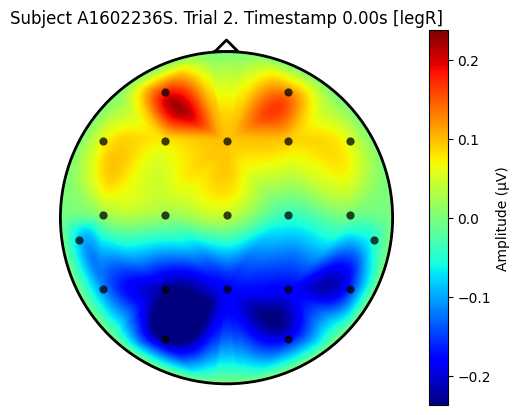

In [9]:
ds4_subject.plot_head(trial=0, plot_joint=True)

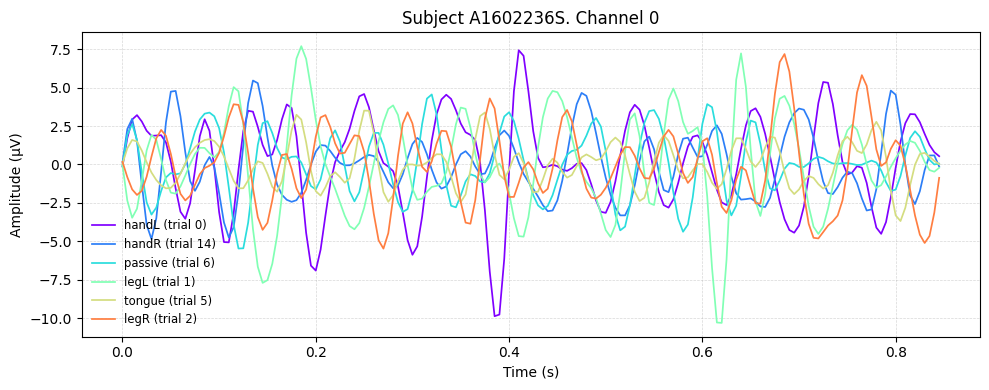

In [10]:
ds4_subject.plot_channel(trial=0, channel=0)

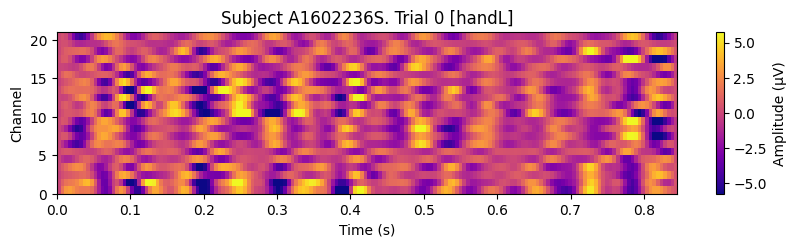

In [11]:
ds4_subject.plot_trial_heatmap(trial=0)

## Dataset 11: Mental-Imagery Dataset
13 participants with over 60,000 examples of motor imageries in 4 interaction paradigms recorded with 38 channels medical-grade EEG system. It contains data for upto 6 mental imageries primarily for the motor moements.

### DS11 File Contents

### DS11 Data Examples

## Classification

In [19]:
X, Y, groups = ds1.get_XY()
X.shape, Y.shape, groups.shape

((3640, 64, 1024), (3640,), (3640,))

### DS1 Baseline

In [20]:
def compute_cov(sample):
    """sample: (n_channels, n_samples) -> normalized covariance (n_channels, n_channels)"""
    C = sample @ sample.T
    tr = np.trace(C)
    return C / tr if tr > 0 else C


def fit_csp(X_train, y_train, n_components=4, reg=1e-10):
    """
    Classic 2-class CSP.
    Returns spatial filters W of shape (n_channels, n_components).
    """
    classes = np.unique(y_train)
    if len(classes) != 2:
        raise ValueError("CSP requires exactly 2 classes.")

    c0, c1 = classes[0], classes[1]
    X0 = X_train[y_train == c0]
    X1 = X_train[y_train == c1]

    C0 = np.mean([compute_cov(x) for x in X0], axis=0)
    C1 = np.mean([compute_cov(x) for x in X1], axis=0)

    # Regularize slightly for stability
    n_ch = C0.shape[0]
    C0 = C0 + reg * np.eye(n_ch)
    C1 = C1 + reg * np.eye(n_ch)

    Cc = C0 + C1

    # Solve generalized eigenvalue problem: C0 w = λ (C0 + C1) w
    # Use standard eig on inv(Cc) @ C0
    evals, evecs = np.linalg.eig(np.linalg.solve(Cc, C0))
    evals = np.real(evals)
    evecs = np.real(evecs)

    # Sort by eigenvalue (most discriminative at extremes)
    idx = np.argsort(evals)
    evecs = evecs[:, idx]

    # Pick extremes: first k/2 and last k/2
    k2 = n_components // 2
    W = np.concatenate([evecs[:, :k2], evecs[:, -k2:]], axis=1)
    return W


def csp_logvar_features(X, W):
    """
    Project: Z = W^T X, then log-variance per component.
    X: (n_trials, n_channels, n_samples)
    W: (n_channels, n_components)
    Returns F: (n_trials, n_components)
    """
    Z = np.einsum("tcj,ck->tkj", X, W)  # (trials, comps, samples)
    var = np.var(Z, axis=-1, ddof=0)
    # normalize variance per trial (optional but common)
    var = var / (np.sum(var, axis=1, keepdims=True) + 1e-12)
    return np.log(var + 1e-12)


def eval_subject_csp_lda(X_subj, y_subj, fs, n_repeats=120, test_frac=0.30, seed=0):
    rng = np.random.default_rng(seed)
    n = len(y_subj)
    idx0 = np.where(y_subj == 0)[0]
    idx1 = np.where(y_subj == 1)[0]

    n_test0 = int(round(len(idx0) * test_frac))
    n_test1 = int(round(len(idx1) * test_frac))

    accs = []
    for _ in range(n_repeats):
        test0 = rng.choice(idx0, size=n_test0, replace=False)
        test1 = rng.choice(idx1, size=n_test1, replace=False)
        test_idx = np.concatenate([test0, test1])
        train_mask = np.ones(n, dtype=bool)
        train_mask[test_idx] = False
        train_idx = np.where(train_mask)[0]

        X_train, y_train = X_subj[train_idx], y_subj[train_idx]
        X_test, y_test = X_subj[test_idx], y_subj[test_idx]

        # CSP fit + features
        W = fit_csp(X_train, y_train, n_components=4)
        F_train = csp_logvar_features(X_train, W)
        F_test = csp_logvar_features(X_test, W)

        # LDA
        clf = LinearDiscriminantAnalysis()
        clf.fit(F_train, y_train)
        accs.append(clf.score(F_test, y_test))

    accs = np.array(accs, dtype=float)
    return float(accs.mean()), float(accs.std())


def evaluate_all_subjects(X, Y, groups, fs=512, n_repeats=120, test_frac=0.30, seed=0):
    subj_ids = np.unique(groups)
    results = {}
    for sid in subj_ids:
        mask = (groups == sid)
        Xs, ys = X[mask], Y[mask]
        mean_acc, std_acc = eval_subject_csp_lda(Xs, ys, fs=fs, n_repeats=n_repeats, test_frac=test_frac, seed=seed)
        results[int(sid)] = (mean_acc, std_acc)
        print(f"s{int(sid):02d}: {mean_acc*100:.2f}% ± {std_acc*100:.2f}%")

    all_means = np.array([v[0] for v in results.values()], dtype=float)
    print("\nOverall (mean across subjects): "
          f"{all_means.mean()*100:.2f}% ± {all_means.std()*100:.2f}% (std across subjects)")
    return results


In [21]:
results = evaluate_all_subjects(X, Y, groups, fs=512, n_repeats=120, test_frac=0.30, seed=42)

s35: 79.14% ± 4.22%
s36: 67.54% ± 7.21%
s37: 62.87% ± 7.86%
s38: 50.81% ± 6.76%
s39: 60.68% ± 5.55%
s40: 50.03% ± 6.36%
s41: 89.24% ± 3.12%
s42: 58.43% ± 5.07%
s43: 96.69% ± 2.70%
s44: 67.92% ± 6.15%
s45: 51.83% ± 5.96%
s46: 80.01% ± 4.17%
s47: 61.14% ± 7.60%
s48: 77.40% ± 10.76%
s49: 75.43% ± 5.29%
s50: 82.15% ± 7.81%
s51: 52.68% ± 6.30%
s52: 67.86% ± 6.36%

Overall (mean across subjects): 68.44% ± 13.37% (std across subjects)
